### Microsoft Movie Studio: Exploratory Data Analysis and Recommendations

### Business Problem
Microsoft is standing up a movie studio, and has tasked us with performing exploratory data analysis to inform their decisions about what films to create. In this notebook, we will perform that analysis and issue recommendations based on our findings.

### Our Data
Financial data used in this notebook is drawn from The Numbers (http://www.the-numbers.com/). Basic movie information is drawn from the Internet Movie Database (IMDB, http://www.imdb.com/). 

### Methods
We begin by cleaning our data to create a dataset that includes movies from 2012 to 2019 - beginning with the year Netflix released its first original, and ending with the final full year before the COVID-19 pandemic disrupted the movie industry. We used descriptive analysis, including tables, visualizations, and rankings to dig into the relationships between production budget, profit, and genre.

### Summary of Recommendations
- Microsoft should be sure to market its films internationally to maximize the value of its production dollar.
- Microsoft should focus on making movies that include a mix of characteristics from the Sci-Fi, Animation, and/or Thriller genres in particular.
- To minimize the risk of significant financial loss from any one movie, Microsoft should avoid making action movies with high budgets.
- Microsoft should avoid hiring David Gordon Green, Simon West, Kevin Smith, Justin Chadwick, James Gray, Mira Nair, Jacques Audiard, and David Koepp to direct movies for its studio.

### Exploratory Data Analysis

In [1]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style = 'darkgrid')
import sqlite3
from scipy import stats
import warnings

warnings.filterwarnings('ignore')

conn = sqlite3.connect("zippedData/im.db")

A key measure of success for any movie is the amount of profit it brings in for its studio. None of our datasets include profit, so we will begin by determining how profitable each movie in our dataset is.

In [2]:
# need a column that denotes profit, so start by importing financial data
movie_finances = pd.read_csv('zippedData/tn.movie_budgets.csv', index_col = 'id')
movie_finances.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross
id,,,,,
1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [3]:
# check data types of seres in movie_finances
movie_finances.dtypes

release_date         object
movie                object
production_budget    object
domestic_gross       object
worldwide_gross      object
dtype: object

Right now, our financial data is stored as objects, which means we won't be able to perform mathematical operations on them. We'll need to fix that in order to proceed.

In [4]:
# write a function to strip characters from Series to make them integers
def strip_char(char, col, df):
    # a character, a column name, and a dataframe as an argument
    # strips that character from all rows in the column and returns the df
    df[col] = df[col].apply(lambda x: x.replace(str(char), ""))
    return df
    
strip_char('$', 'production_budget', movie_finances)
strip_char(',', 'production_budget', movie_finances)
strip_char('$', 'domestic_gross', movie_finances)
strip_char(',', 'domestic_gross', movie_finances)
strip_char('$', 'worldwide_gross', movie_finances)
strip_char(',', 'worldwide_gross', movie_finances)

,release_date,movie,production_budget,domestic_gross,worldwide_gross
id,,,,,
1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279
2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875
3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350
4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963
5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747
...,...,...,...,...,...
78,"Dec 31, 2018",Red 11,7000,0,0
79,"Apr 2, 1999",Following,6000,48482,240495
80,"Jul 13, 2005",Return to the Land of Wonders,5000,1338,1338


In [5]:
# change dtype to int
movie_finances['production_budget'] = movie_finances['production_budget'].astype(int)
movie_finances['domestic_gross'] = movie_finances['domestic_gross'].astype(int)
movie_finances['worldwide_gross'] = movie_finances['worldwide_gross'].astype(int)

In [6]:
# confirm dtypes have been updated
movie_finances.dtypes

release_date         object
movie                object
production_budget     int64
domestic_gross        int64
worldwide_gross       int64
dtype: object

Now that we have cleaned the dataset, we can determine the domestic and worldwide profit for each movie. We will do so by subtracting the production budget from the domestic gross to determine domestic profit, and from the worldwide gross to determine worldwide profit. Further, we will subtract the domestic profit from the worldwide profit to determine the amount of profit earned outside of North America, which we will call "international profit".

In [7]:
# calculate domestic profit and save in a new column
movie_finances['domestic_profit'] = movie_finances['domestic_gross'] - movie_finances['production_budget']

# calculate worldwide profit and save in a new column
movie_finances['worldwide_profit'] = movie_finances['worldwide_gross'] - movie_finances['production_budget']

# calculate international profit and save in a new column
movie_finances['international_profit'] = movie_finances['worldwide_profit'] - movie_finances['domestic_profit']

movie_finances

,release_date,movie,production_budget,domestic_gross,worldwide_gross,domestic_profit,worldwide_profit,international_profit
id,,,,,,,,
1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,335507625,2351345279,2015837654
2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,-169536125,635063875,804600000
3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,-307237650,-200237650,107000000
4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,128405868,1072413963,944008095
5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,303181382,999721747,696540365
...,...,...,...,...,...,...,...,...
78,"Dec 31, 2018",Red 11,7000,0,0,-7000,-7000,0
79,"Apr 2, 1999",Following,6000,48482,240495,42482,234495,192013
80,"Jul 13, 2005",Return to the Land of Wonders,5000,1338,1338,-3662,-3662,0


Let's also add some more information about each movie's genre(s) that we can use later in our analysis.

In [8]:
# get movie characteristics from im.db
movie_basics = pd.read_sql("""
SELECT movie_id, primary_title, genres
  FROM movie_basics
""", conn)

movie_basics

,movie_id,primary_title,genres
0,tt0063540,Sunghursh,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,Drama
3,tt0069204,Sabse Bada Sukh,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,"Comedy,Drama,Fantasy"
...,...,...,...
146139,tt9916538,Kuambil Lagi Hatiku,Drama
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Documentary
146141,tt9916706,Dankyavar Danka,Comedy
146142,tt9916730,6 Gunn,None


In [9]:
# create a merged dataframe with information from both of these tables
movie_info = pd.merge(movie_finances, movie_basics, how = 'inner', left_on = 'movie', right_on = 'primary_title')
movie_info.drop('primary_title', axis = 1, inplace = True)

Now we have a comprehensive set of information on each movie that includes profit, genre, and release year. However, it's clear that the movie landscape has shifted dramatically in the last decade as digital native media companies like Netflix, legacy studios like Disney, and tech companies like Apple have begun creating and releasing original content. Let's narrow down our dataset to only include information on movies released since 2012 (when Netflix released its first Netflix Original, kicking off the modern era of the "Streaming Wars").

In [10]:
# extract the year from the release date and make it an integer
movie_info['release_year'] = movie_info['release_date'].str[-4:].astype(int)

In [11]:
movies_last_decade = movie_info.loc[movie_info['release_year'] >= 2012]
movies_last_decade.reset_index(inplace = True)
movies_last_decade.drop('index', axis = 1, inplace = True)
movies_last_decade

,release_date,movie,production_budget,domestic_gross,worldwide_gross,domestic_profit,worldwide_profit,international_profit,movie_id,genres,release_year
0,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,-307237650,-200237650,107000000,tt6565702,"Action,Adventure,Sci-Fi",2019
1,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,128405868,1072413963,944008095,tt2395427,"Action,Adventure,Sci-Fi",2015
2,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,378815482,1748134200,1369318718,tt4154756,"Action,Adventure,Sci-Fi",2018
3,"Nov 17, 2017",Justice League,300000000,229024295,655945209,-70975705,355945209,426920914,tt0974015,"Action,Adventure,Fantasy",2017
4,"Nov 6, 2015",Spectre,300000000,200074175,879620923,-99925825,579620923,679546748,tt2379713,"Action,Adventure,Thriller",2015
...,...,...,...,...,...,...,...,...,...,...,...
2053,"Apr 21, 2015",The Front Man,20000,0,0,-20000,-20000,0,tt2357398,"Biography,Comedy,Documentary",2015
2054,"Dec 31, 2014",Stories of Our Lives,15000,0,0,-15000,-15000,0,tt3973612,Drama,2014
2055,"Jan 13, 2012",Newlyweds,9000,4584,4584,-4416,-4416,0,tt1880418,"Comedy,Drama",2012
2056,"Dec 31, 2018",Red 11,7000,0,0,-7000,-7000,0,tt7837402,"Horror,Sci-Fi,Thriller",2018


In [12]:
movies_last_decade.isna().sum()

release_date             0
movie                    0
production_budget        0
domestic_gross           0
worldwide_gross          0
domestic_profit          0
worldwide_profit         0
international_profit     0
movie_id                 0
genres                  27
release_year             0
dtype: int64

Since there are only 27 null values in our dataset, representing just over 1% of our total records, let's drop rows with null values so we can operate from a clean starting point.

In [13]:
# drop null values
movies_last_decade.dropna(inplace = True)

# make sure they're gone
movies_last_decade.isna().sum()

release_date            0
movie                   0
production_budget       0
domestic_gross          0
worldwide_gross         0
domestic_profit         0
worldwide_profit        0
international_profit    0
movie_id                0
genres                  0
release_year            0
dtype: int64

Further, while our dataset includes data on movies from 2020, that year was an outlier due to the sudden onset of the COVID-19 pandemic. It would not be representative of broader conditions in the movie industry to include data from that year since theaters were forced to close early in the year, so we will drop values from that year and limit our observations to movies from 2012-2019.

In [14]:
# find movies from 2020
movies_last_decade.loc[movies_last_decade['release_year'] == 2020]

,release_date,movie,production_budget,domestic_gross,worldwide_gross,domestic_profit,worldwide_profit,international_profit,movie_id,genres,release_year
285,"Feb 21, 2020",Call of the Wild,82000000,0,0,-82000000,-82000000,0,tt7504726,"Adventure,Animation,Family",2020


There is only one film in our dataset from 2020, so we can remove that row individually:

In [15]:
# remove row by index
movies_last_decade.drop(285, inplace = True)
movies_last_decade.reset_index(inplace = True)
movies_last_decade.drop('index', axis = 1, inplace = True)
movies_last_decade

,release_date,movie,production_budget,domestic_gross,worldwide_gross,domestic_profit,worldwide_profit,international_profit,movie_id,genres,release_year
0,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,-307237650,-200237650,107000000,tt6565702,"Action,Adventure,Sci-Fi",2019
1,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,128405868,1072413963,944008095,tt2395427,"Action,Adventure,Sci-Fi",2015
2,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,378815482,1748134200,1369318718,tt4154756,"Action,Adventure,Sci-Fi",2018
3,"Nov 17, 2017",Justice League,300000000,229024295,655945209,-70975705,355945209,426920914,tt0974015,"Action,Adventure,Fantasy",2017
4,"Nov 6, 2015",Spectre,300000000,200074175,879620923,-99925825,579620923,679546748,tt2379713,"Action,Adventure,Thriller",2015
...,...,...,...,...,...,...,...,...,...,...,...
2025,"Apr 21, 2015",The Front Man,20000,0,0,-20000,-20000,0,tt2357398,"Biography,Comedy,Documentary",2015
2026,"Dec 31, 2014",Stories of Our Lives,15000,0,0,-15000,-15000,0,tt3973612,Drama,2014
2027,"Jan 13, 2012",Newlyweds,9000,4584,4584,-4416,-4416,0,tt1880418,"Comedy,Drama",2012
2028,"Dec 31, 2018",Red 11,7000,0,0,-7000,-7000,0,tt7837402,"Horror,Sci-Fi,Thriller",2018


We're also only interested in movies that earned any gross revenue, since Microsoft has tasked us with exploring what types of films are currently doing the best at the box office. Let's remove all the movies from our dataset that earned no gross revenue worldwide.

In [16]:
# find movies with no revenue worldwide
no_revenue = movies_last_decade.loc[movies_last_decade['worldwide_gross'] == 0]

# drop these movies from our dataset
movies_last_decade.drop(no_revenue.index, inplace = True)
movies_last_decade.reset_index(inplace = True)
movies_last_decade.drop('index', axis = 1, inplace = True)
movies_last_decade

,release_date,movie,production_budget,domestic_gross,worldwide_gross,domestic_profit,worldwide_profit,international_profit,movie_id,genres,release_year
0,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,-307237650,-200237650,107000000,tt6565702,"Action,Adventure,Sci-Fi",2019
1,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,128405868,1072413963,944008095,tt2395427,"Action,Adventure,Sci-Fi",2015
2,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,378815482,1748134200,1369318718,tt4154756,"Action,Adventure,Sci-Fi",2018
3,"Nov 17, 2017",Justice League,300000000,229024295,655945209,-70975705,355945209,426920914,tt0974015,"Action,Adventure,Fantasy",2017
4,"Nov 6, 2015",Spectre,300000000,200074175,879620923,-99925825,579620923,679546748,tt2379713,"Action,Adventure,Thriller",2015
...,...,...,...,...,...,...,...,...,...,...,...
1755,"Jan 27, 2017",Emily,27000,3547,3547,-23453,-23453,0,tt4393036,Drama,2017
1756,"Jan 27, 2017",Emily,27000,3547,3547,-23453,-23453,0,tt4883762,Documentary,2017
1757,"Sep 1, 2015",Exeter,25000,0,489792,-25000,464792,489792,tt1945044,"Horror,Mystery,Thriller",2015
1758,"Sep 1, 2015",Exeter,25000,0,489792,-25000,464792,489792,tt2782686,Horror,2015


Finally, we need to ensure there are no duplicate rows in our dataset. Let's check for and remove any duplicates:

In [17]:
# check for duplicate movie names
movies_last_decade['movie'].value_counts()

Home                 24
Freedom              14
Brothers             13
The Gift             13
The Wall             10
                     ..
The Bronze            1
The Expendables 3     1
Machete Kills         1
Hotel Artemis         1
Rudderless            1
Name: movie, Length: 1231, dtype: int64

In [18]:
# drop rows based on duplicate movie names
movies_last_decade.drop_duplicates(subset = ['movie'], inplace = True)

#check if all movie name values are unique
movies_last_decade['movie'].value_counts()

Patti Cake$                    1
Your Sister's Sister           1
Accidental Love                1
Mad Max: Fury Road             1
Kill List                      1
                              ..
Bridge of Spies                1
Get Hard                       1
Julija in alfa Romeo           1
Kingsman: The Golden Circle    1
Rudderless                     1
Name: movie, Length: 1231, dtype: int64

Excellent - now we have a dataset with over 1,200 records and no missing or duplicate values.

### Return On Production Investment for Domestic vs. International Markets
Now that we have a clean dataset, we can examine the descriptive statistics for our dataset as a whole to learn a little bit about the distribution of the data.

In [19]:
movies_last_decade.describe()

,production_budget,domestic_gross,worldwide_gross,domestic_profit,worldwide_profit,international_profit,release_year
count,1.231000e+03,1.231000e+03,1.231000e+03,1.231000e+03,1.231000e+03,1.231000e+03,1231.000000
mean,4.368616e+07,5.573035e+07,1.417801e+08,1.204419e+07,9.809395e+07,8.604976e+07,2014.897644
std,5.619363e+07,8.768790e+07,2.410422e+08,6.209980e+07,2.000476e+08,1.607699e+08,2.009551
min,9.000000e+03,0.000000e+00,2.600000e+01,-3.072376e+08,-2.002376e+08,0.000000e+00,2012.000000
25%,7.500000e+06,3.128357e+06,7.781388e+06,-1.112434e+07,-9.080450e+05,1.945016e+06,2013.000000
50%,2.100000e+07,2.537998e+07,4.684436e+07,-4.994720e+05,2.155696e+07,1.969504e+07,2015.000000
75%,5.500000e+07,6.500780e+07,1.523394e+08,2.267983e+07,1.020635e+08,8.653341e+07,2016.000000
max,3.500000e+08,7.000596e+08,2.048134e+09,5.000596e+08,1.748134e+09,1.369319e+09,2019.000000


We can see that the data in our columns are spread over a wide range - from movies that cost less than $10,000 to make and earned little money at the box office to movies that cost hundreds of millions to bring to life and brought in hundreds of millions or even billions of dollars in profit. We can use a scatter plot to see how each of these variables are correlated:

In [20]:
# calculate correlation between domestic / international profit and production budget
dom_corr = round((movies_last_decade['domestic_profit'].corr(movies_last_decade['production_budget'])), 2)
int_corr = round((movies_last_decade['international_profit'].corr(movies_last_decade['production_budget'])), 2)

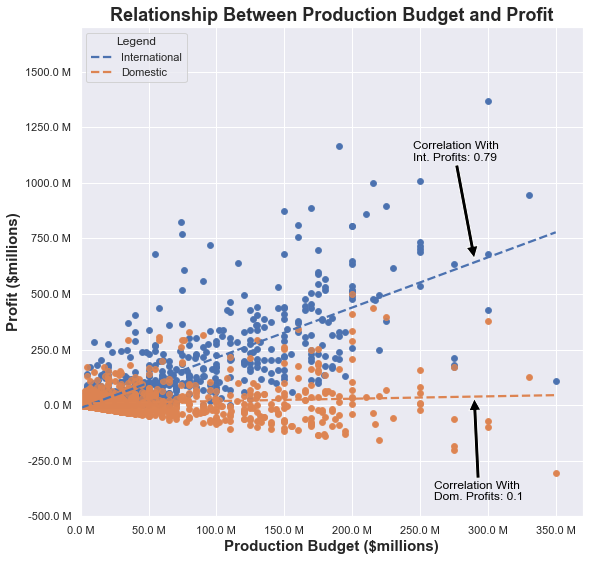

In [21]:
fig, ax = plt.subplots(figsize = (9, 9))

# create scatterplots for domestic and international profit vs. production budget
sns.scatterplot(data = movies_last_decade, x = 'production_budget', y = 'international_profit', legend = 'brief')
sns.scatterplot(data = movies_last_decade, x = 'production_budget', y = 'domestic_profit', legend = 'brief')

def million_formatter(x, pos):
    return "%.1f M" % (x/1E6)

# create regression plots to show linear relationships
sns.regplot(data = movies_last_decade, x = 'production_budget', y = 'international_profit', line_kws={'ls':'--'}, ci = None)
sns.regplot(data = movies_last_decade, x = 'production_budget', y = 'domestic_profit', line_kws={'ls':'--'}, ci = None)

# create labels, axes, and title for axis
ax.set_xlabel('Production Budget ($millions)', fontsize = 15, weight = 'bold')
ax.set_ylabel('Profit ($millions)', fontsize = 15, weight = 'bold')
ax.set_title('Relationship Between Production Budget and Profit', fontsize = 18, weight = 'bold')
ax.set_xticks(range(0, 375000000, 10000000), minor = True)
ax.set_yticks(range(-500000000, 1750000000, 100000000), minor = True)
ax.xaxis.set_major_formatter(million_formatter)
ax.yaxis.set_major_formatter(million_formatter)
plt.legend(title = 'Legend', loc = 'upper left', labels = ['International', 'Domestic'])

# annotate regplots with correlation values
ax.annotate(f'Correlation With\nInt. Profits: {int_corr}',  \
            xy=(290000000, 660000000), xytext=(245000000, 1100000000),\
            arrowprops={'facecolor': 'black'}, fontsize = 12, c = 'black')
ax.annotate(f'Correlation With\nDom. Profits: {dom_corr}',  \
            xy=(290000000, 30000000), xytext=(260000000, -428000000),\
            arrowprops={'facecolor': 'black'}, fontsize = 12, c = 'black')

plt.show();

It's clear from this graph that there is a positive relationship between the amount of money companies make internationally and the amount of money that is invested into their production, and that on average films earn more on the international market per dollar spent on production than they do domestically. This leads us to our first recommendation: **Microsoft should be sure to market its films internationally to maximize the value of its production dollar.**

### Maximizing the Value of Microsoft's Investment
Earning the highest possible overall profit is a key factor for Microsoft to consider in standing up its new enterprise, but the company does not have an infinite budget to do so. The Microsoft movie studio will have to ensure it is investing wisely to maximize the value of each dollar it invests. Consequently, our analysis will focus next on which movie genres perform the best in terms of profit dollar earned per production dollar invested, which we will call the profit ratio for the movie.

We will begin by creating new columns in our dataframe to calculate the domestic, international, and worldwide profit ratio for each movie in our dataset.

In [22]:
# create a copy of the DataFrame
profit_ratios = movies_last_decade.copy()

# create new columns in copy
profit_ratios['domestic_profit_ratio'] = profit_ratios['domestic_profit'] / profit_ratios['production_budget']
profit_ratios['international_profit_ratio'] = profit_ratios['international_profit'] / profit_ratios['production_budget']
profit_ratios['worldwide_profit_ratio'] = profit_ratios['worldwide_profit'] / profit_ratios['production_budget']

# check that it worked
profit_ratios.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross,domestic_profit,worldwide_profit,international_profit,movie_id,genres,release_year,domestic_profit_ratio,international_profit_ratio,worldwide_profit_ratio
0,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,-307237650,-200237650,107000000,tt6565702,"Action,Adventure,Sci-Fi",2019,-0.877822,0.305714,-0.572108
1,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,128405868,1072413963,944008095,tt2395427,"Action,Adventure,Sci-Fi",2015,0.388403,2.855439,3.243841
2,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,378815482,1748134200,1369318718,tt4154756,"Action,Adventure,Sci-Fi",2018,1.262718,4.564396,5.827114
3,"Nov 17, 2017",Justice League,300000000,229024295,655945209,-70975705,355945209,426920914,tt0974015,"Action,Adventure,Fantasy",2017,-0.236586,1.423070,1.186484
4,"Nov 6, 2015",Spectre,300000000,200074175,879620923,-99925825,579620923,679546748,tt2379713,"Action,Adventure,Thriller",2015,-0.333086,2.265156,1.932070


Now that we have this data, we need to figure out how to best characterize the genre of a movie. We have a 'genres' column already, but most movies appear to be a mix of several genres. In order to determine the best mix of genres for each market, let's start by separating this column into each component genre.

In [23]:
# convert each row in this column to a list to prepare for explosion
profit_ratios['genres'] = profit_ratios['genres'].apply(lambda x: x.split(','))

# explode the genres column to create a unique row for each genre of a movie
profit_ratios = profit_ratios.explode('genres')

Let's see what our distribution of genres looks like.

In [24]:
profit_ratios.value_counts('genres')

genres
Drama          618
Comedy         394
Action         341
Adventure      287
Thriller       202
Crime          187
Romance        145
Horror         143
Biography      126
Sci-Fi         111
Mystery        103
Fantasy         96
Animation       83
Family          59
Documentary     53
History         48
Music           45
Sport           26
War             16
Musical          6
Western          6
dtype: int64

Now that we've broken each record down by its component genres, we can group by those characteristics to determine which specific genre has the highest mean profit ratio in the domestic and international markets.

In [25]:
# create a subset that calculates the mean profit ratio by genre for each market
ratios_by_genre = profit_ratios.groupby('genres')['domestic_profit_ratio', 'international_profit_ratio'].mean()
ratios_by_genre

,domestic_profit_ratio,international_profit_ratio
genres,,
Action,0.226486,1.753712
Adventure,0.224718,1.939758
Animation,0.380741,2.377991
Biography,0.714252,1.661037
Comedy,0.886427,1.704128
Crime,0.143427,1.032298
Documentary,0.743959,1.043753
Drama,0.655784,1.515024
Family,0.442320,1.316888


We can visualize this data with a bar chart to see where each genre's profit ratio is similar across markets, and where they differ.

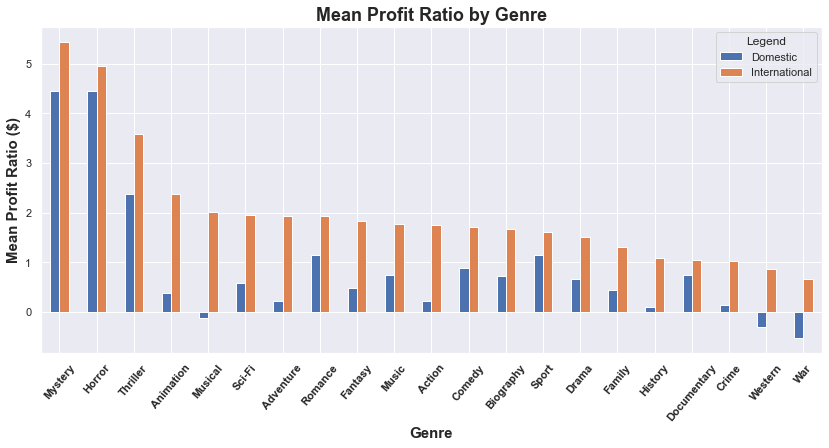

In [26]:
fig, ax = plt.subplots(figsize = (14, 6))

# create barplots for mean profit ratio of each genre
ratios_by_genre.sort_values(by = 'international_profit_ratio', ascending = False).plot(kind = 'bar', ax = ax)

# create labels, axes, and title for graph
ax.set_xlabel('Genre', fontsize = 15, weight = 'bold')
ax.set_ylabel('Mean Profit Ratio ($)', fontsize = 15, weight = 'bold')
ax.set_title('Mean Profit Ratio by Genre', fontsize = 18, weight = 'bold')
plt.legend(title = 'Legend', loc = 'upper right', labels = ['Domestic', 'International'])
plt.xticks(rotation=50, weight = 'bold')

plt.show();

Now let's compare this to overall mean profit by genre:

In [27]:
# create a subset that calculates the mean profit by genre for each market
profits_by_genre = profit_ratios.groupby('genres')['domestic_profit', 'international_profit'].mean()
profits_by_genre

,domestic_profit,international_profit
genres,,
Action,9.885861e+06,1.701389e+08
Adventure,1.734647e+07,2.269048e+08
Animation,3.745666e+07,2.206433e+08
Biography,1.236110e+07,4.123681e+07
Comedy,1.953548e+07,7.628790e+07
Crime,3.785538e+06,4.462112e+07
Documentary,8.954344e+06,1.788584e+07
Drama,6.446380e+06,4.046060e+07
Family,8.912203e+06,1.141241e+08


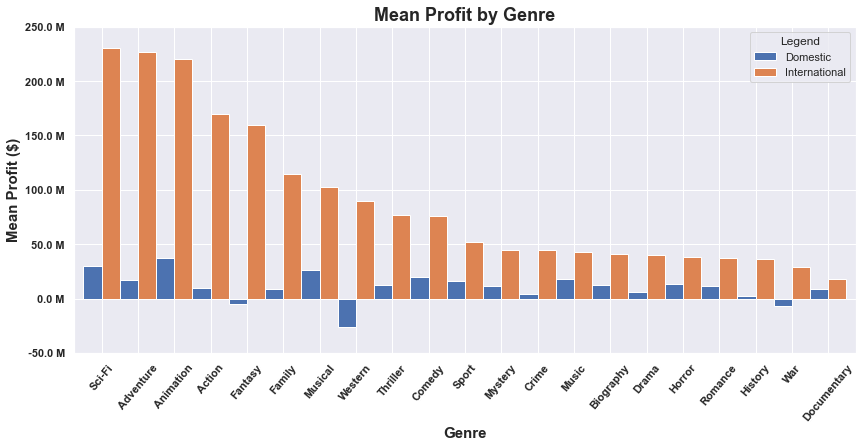

In [28]:
fig, ax = plt.subplots(figsize = (14, 6))

# create barplots for mean profit ratio of each genre
profits_by_genre.sort_values(by = 'international_profit', ascending = False).plot(kind = 'bar', ax = ax, width = 1)

# create labels, axes, and title for graph
def million_formatter(x, pos):
    return "%.1f M" % (x/1E6)

ax.set_xlabel('Genre', fontsize = 15, weight = 'bold')
ax.set_ylabel('Mean Profit ($)', fontsize = 15, weight = 'bold')
ax.set_title('Mean Profit by Genre', fontsize = 18, weight = 'bold')
ax.set_yticks(range(-50000000, 275000000, 100000000), minor = True)
ax.yaxis.set_major_formatter(million_formatter)
plt.xticks(rotation=50, weight = 'bold')
plt.yticks(weight = 'bold')
plt.legend(title = 'Legend', loc = 'upper right', labels = ['Domestic', 'International'])

plt.show();

Interesting - it looks like there is a substantial difference in which genres have the greatest profit ratios on average, vs. which genres earn the most profit on average. In order to make our second recommendation, let's rank each genre by its domestic and international mean profits and profit ratios, and average those rankings to reach a composite overall ranking that accounts for both value and overall profit potential.

In [29]:
# create the individual rankings
profits_by_genre['domestic_profit_rank'] = profits_by_genre['domestic_profit'].rank(ascending = False)
profits_by_genre['international_profit_rank'] = profits_by_genre['international_profit'].rank(ascending = False)
ratios_by_genre['domestic_profit_ratio_rank'] = ratios_by_genre['domestic_profit_ratio'].rank(ascending = False)
ratios_by_genre['international_profit_ratio_rank'] = ratios_by_genre['international_profit_ratio'].rank(ascending = False)

Finally, let's bring these rankings together and create our composite ranking. The genre with the lowest average ranking is the genre that provides the best mix of value per production dollar spent and highest average profit per movie release for that genre across both the domestic and international markets.

In [30]:
# merge rankings from individuals dataframes
genre_rankings = pd.merge(profits_by_genre[['domestic_profit_rank',\
                                            'international_profit_rank']],\
                          ratios_by_genre[['domestic_profit_ratio_rank',\
                                           'international_profit_ratio_rank']],\
                          on = 'genres')

#calculate average ranking
genre_rankings['average_ranking'] = (genre_rankings['domestic_profit_rank'] +\
                                     genre_rankings['international_profit_rank'] +\
                                     genre_rankings['domestic_profit_ratio_rank'] +\
                                     genre_rankings['international_profit_ratio_rank']) / 4

#sort by lowest ranking, which equates to best average
genre_rankings.sort_values('average_ranking')

,domestic_profit_rank,international_profit_rank,domestic_profit_ratio_rank,international_profit_ratio_rank,average_ranking
genres,,,,,
Sci-Fi,2.0,1.0,11.0,6.0,5.00
Animation,1.0,3.0,14.0,4.0,5.50
Thriller,10.0,9.0,3.0,3.0,6.25
Mystery,12.0,12.0,1.0,1.0,6.50
Horror,8.0,17.0,2.0,2.0,7.25
Adventure,6.0,2.0,16.0,7.0,7.75
Comedy,4.0,10.0,6.0,12.0,8.00
Musical,3.0,7.0,19.0,5.0,8.50
Sport,7.0,11.0,5.0,14.0,9.25


The genre characteristics that, on average, provide the best mix of value and profit maximization are at the top of this ranking. This leads to our second recommendation: **Microsoft should focus on making movies that include a mix of characteristics from the Sci-Fi, Animation, and/or Thriller genres in particular.** Films with Mystery, Horror, Adventure, Comedy, Musical, Sport, and Music (movies about music and/or musicians) round out the top 10.

### Avoiding "Clunkers"
Our first two recommendations have been about profit maximization - what market(s) to emphasize in rolling out films, and what genre(s) to focus on when making movies to achieve the best mix of high value and high profit ceiling. Our last recommendation will focus instead on loss minimization and risk mitigation by examining the characteristics of what we will call "clunkers" - movies that lost money on the worldwide market. Let's start by creating a subset of our data that only includes these films.

In [31]:
# create a clunkers subset, drop unnecessary columns, and examine the head
clunkers = movies_last_decade.loc[movies_last_decade['worldwide_profit'] <= 0]
clunkers.drop(['domestic_gross', 'worldwide_gross',\
               'domestic_profit', 'international_profit'],\
              axis = 1, inplace = True)
clunkers.reset_index(inplace = True)
clunkers.sort_values('worldwide_profit').head(25)

,index,release_date,movie,production_budget,worldwide_profit,movie_id,genres,release_year
0,0,"Jun 7, 2019",Dark Phoenix,350000000,-200237650,tt6565702,"Action,Adventure,Sci-Fi",2019
9,210,"Jun 14, 2019",Men in Black: International,110000000,-106900000,tt2283336,"Action,Adventure,Comedy",2019
13,257,"Apr 21, 2017",The Promise,90000000,-79448583,tt10013288,Drama,2017
22,347,"Oct 26, 2018",Air Strike,65000000,-64483721,tt4743226,"Action,Adventure,Drama",2018
8,187,"Jan 13, 2017",Monster Trucks,125000000,-63357202,tt3095734,"Action,Adventure,Comedy",2017
7,173,"Jul 19, 2013",R.I.P.D.,130000000,-50923322,tt0790736,"Action,Adventure,Comedy",2013
17,321,"Jan 16, 2015",Blackhat,70000000,-50334996,tt2717822,"Action,Crime,Thriller",2015
43,488,"Dec 31, 2012",Foodfight!,45000000,-44926294,tt0249516,"Action,Animation,Comedy",2012
21,346,"Dec 25, 2016",Live by Night,65000000,-43225568,tt2361317,"Action,Crime,Drama",2016
35,448,"Apr 17, 2015",Child 44,50000000,-41995779,tt1014763,"Crime,Drama,History",2015


That is a **lot** of action movies in the 25 biggest clunkers in our dataset. Let's see if there's a difference in how much action clunkers lose vs. clunkers from other genres.

In [32]:
# create new categorical variable of Action or Not Action
clunkers['action'] = clunkers['genres'].apply(lambda x: 'Action' if 'Action' in x else "Not Action")
clunkers.groupby('action')['worldwide_profit'].mean()

action
Action       -1.869387e+07
Not Action   -7.515946e+06
Name: worldwide_profit, dtype: float64

We can visualize the distribution of losses with a box plot.

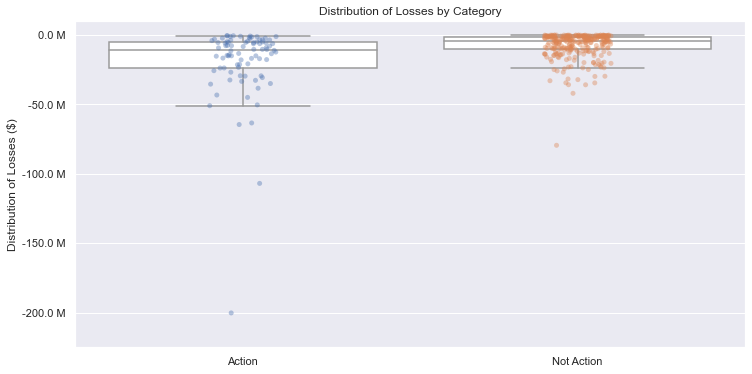

In [33]:
fig, ax = plt.subplots(figsize = (12, 6))

# create the boxplots from our data
sns.boxplot(data = clunkers, x = "action", y = "worldwide_profit", color = 'white',\
            showfliers = False, flierprops = dict(markerfacecolor = '0.50', markersize = 2))
plt.setp(ax.collections, alpha=.3)

sns.stripplot(data = clunkers, x = "action", y = "worldwide_profit", orient = 'v', alpha = 0.4)

def million_formatter(x, pos):
    return "%.1f M" % (x/1E6)

ax.set_xlabel('')
ax.set_ylabel('Distribution of Losses ($)')
ax.set_title('Distribution of Losses by Category')
ax.set_yticks(range(-225000000, 0, 100000000), minor = True)
ax.yaxis.set_major_formatter(million_formatter);

It looks like when action movies flop, they do much worse on average than non-action movies. But there are also some outliers in our dataset that may be skewing our data - what does it look like with these removed?

In [34]:
# find the 99th percentile for our dataset
# because values are negative, need first percentile
q = clunkers['worldwide_profit'].quantile(0.01)

#identify rows that are above the 99th percentile
clunkers_outliers = clunkers.loc[clunkers['worldwide_profit'] <= q]
clunkers_outliers

,index,release_date,movie,production_budget,worldwide_profit,movie_id,genres,release_year,action
0,0,"Jun 7, 2019",Dark Phoenix,350000000,-200237650,tt6565702,"Action,Adventure,Sci-Fi",2019,Action
9,210,"Jun 14, 2019",Men in Black: International,110000000,-106900000,tt2283336,"Action,Adventure,Comedy",2019,Action
13,257,"Apr 21, 2017",The Promise,90000000,-79448583,tt10013288,Drama,2017,Not Action
22,347,"Oct 26, 2018",Air Strike,65000000,-64483721,tt4743226,"Action,Adventure,Drama",2018,Action


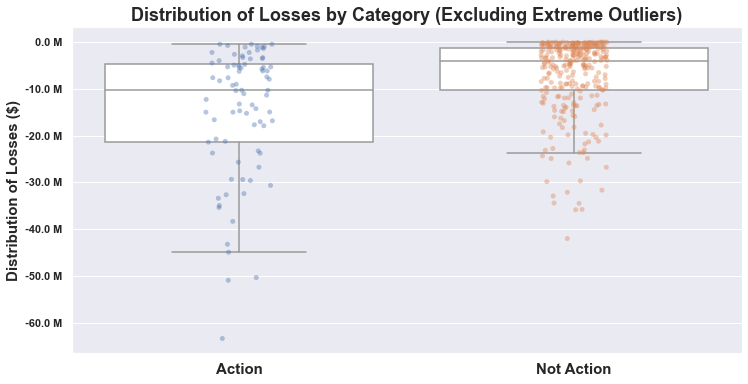

In [35]:
# now drop these outliers from data
clunkers_no_outliers = clunkers.drop(clunkers_outliers.index)
clunkers_no_outliers

#replot without outliers
fig, ax = plt.subplots(figsize = (12, 6))

box = sns.boxplot(data = clunkers_no_outliers, x = "action",\
                  y = "worldwide_profit", color = 'white', showfliers = False)
plt.setp(ax.collections, alpha=.3)

sns.stripplot(data = clunkers_no_outliers, x = "action",\
              y = "worldwide_profit", orient = 'v', alpha = 0.4)

def million_formatter(x, pos):
    return "%.1f M" % (x/1E6)

ax.set_xlabel('')
ax.set_ylabel('Distribution of Losses ($)', fontsize = 15, weight = 'bold')
ax.set_title('Distribution of Losses by Category (Excluding Extreme Outliers)', fontsize = 18, weight = 'bold')
ax.set_yticks(range(-100000000, 0, 100000000), minor = True)
plt.xticks(weight = 'bold', fontsize = 15)
plt.yticks(weight = 'bold')
ax.yaxis.set_major_formatter(million_formatter);

In [36]:
clunkers_no_outliers.groupby(['action'])['worldwide_profit'].median()

action
Action       -10319750
Not Action    -4148310
Name: worldwide_profit, dtype: int64

Clearly, on average, action movies that lose money lose more than non-action movies, even without outliers in consideration. Taking into account our full dataset, including the outliers we had previously excluded, it's clear that action movies that lose money lose more than do non-action movies. Qualitatively, we can see from the head of our full dataset that action movies with high budgets lose the most money, which makes sense - if you start by spending a lot of money to make your movie, you have to make a lot more money back to avoid a loss (or even earn a profit)!
This leads to our fourth recommendation: **to minimize the risk of a costly clunker, Microsoft should avoid making action movies with high budgets.**

### Dismal Directors

Finally, let's look at directors who have been responsible for some of our clunkers.

In [37]:
# get director info from im.db directors table
directors = pd.read_sql("""
SELECT *
  FROM directors
""", conn)

In [38]:
# get information from im.db persons table
names = pd.read_sql('''
SELECT * 
FROM persons
''', conn)

In [39]:
# merge director ids with names
director_names = pd.merge(directors, names , how = 'inner', on = 'person_id')
director_names.drop_duplicates(subset = ['movie_id'], inplace = True)
director_names

,movie_id,person_id,primary_name,birth_year,death_year,primary_profession
0,tt0285252,nm0899854,Tony Vitale,1964.0,NaN,"producer,director,writer"
1,tt0462036,nm1940585,Bill Haley,NaN,NaN,"director,writer,producer"
2,tt0835418,nm0151540,Jay Chandrasekhar,1968.0,NaN,"director,actor,writer"
4,tt0859635,nm0151540,Jay Chandrasekhar,1968.0,NaN,"director,actor,writer"
9,tt0878654,nm0089502,Albert Pyun,1954.0,NaN,"director,writer,producer"
...,...,...,...,...,...,...
291164,tt8998302,nm10121510,Daryl Boman,NaN,NaN,"producer,director,writer"
291165,tt8999892,nm10122247,C. Damon Adcock,NaN,NaN,None
291167,tt8999974,nm10122357,Daysi Burbano,NaN,NaN,"director,writer,cinematographer"
291168,tt9001390,nm6711477,Bernard Lessa,NaN,NaN,"director,writer,cinematographer"


Now we can merge our directors with our clunkers to create a complete record.

In [40]:
# merge dataframes to include director names
clunkers_directors = pd.merge(clunkers, director_names[['movie_id', 'primary_name']], on = 'movie_id', how = 'inner')

# make column name clearer
clunkers_directors.rename(columns = {'primary_name': 'director_name'}, inplace = True)

Finally, let's add a column to classify each movie as a "Major" clunker that lost 1 million dollars or more, vs. a "Minor" clunker that lost less than 1 million dollars.

In [41]:
# lambda function to assign a value to 'major' column
clunkers_directors['major'] = clunkers_directors['worldwide_profit'].apply(lambda x: "Major" if x <= -1000000 else "Minor")
clunkers_directors

,index,release_date,movie,production_budget,worldwide_profit,movie_id,genres,release_year,action,director_name,major
0,0,"Jun 7, 2019",Dark Phoenix,350000000,-200237650,tt6565702,"Action,Adventure,Sci-Fi",2019,Action,Simon Kinberg,Major
1,7,"Jul 2, 2013",The Lone Ranger,275000000,-14997885,tt1210819,"Action,Adventure,Western",2013,Action,Gore Verbinski,Major
2,24,"Nov 21, 2018",Robin Hood,99000000,-14252559,tt0955308,"Action,Adventure,Drama",2018,Action,Ridley Scott,Major
3,77,"May 12, 2017",King Arthur: Legend of the Sword,175000000,-35369664,tt1972591,"Action,Adventure,Drama",2017,Action,Guy Ritchie,Major
4,78,"Dec 25, 2013",47 Ronin,175000000,-23283185,tt1335975,"Action,Adventure,Drama",2013,Action,Carl Rinsch,Major
...,...,...,...,...,...,...,...,...,...,...,...
364,1750,"Jul 25, 2014",Happy Christmas,70000,-39688,tt2955096,"Comedy,Drama",2014,Not Action,Joe Swanberg,Minor
365,1751,"Jan 25, 2013",Supporting Characters,60000,-55083,tt1874789,Comedy,2013,Not Action,Daniel Schechter,Minor
366,1752,"Jul 31, 2015",Counting,50000,-41626,tt4462082,Documentary,2015,Not Action,Jem Cohen,Minor
367,1754,"Jan 27, 2017",Emily,27000,-23453,tt1863224,Drama,2017,Not Action,Timothy McNeil,Minor


In [42]:
# count of major vs. minor clunkers
clunkers_directors['major'].value_counts()

Major    301
Minor     68
Name: major, dtype: int64

How have the number of major vs. minor clunkers trended by year?

In [43]:
# count of major clunkers by year
major_by_year = clunkers_directors.groupby('release_year')['major'].apply(lambda x: x[x.str.contains('Maj')].count())

# count of minor clunkers by year
minor_by_year = clunkers_directors.groupby('release_year')['major'].apply(lambda x: x[x.str.contains('Min')].count())

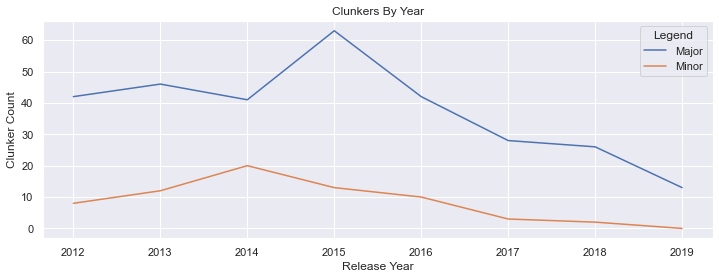

In [44]:
fig, ax = plt.subplots(figsize = (12, 4))

# create line plots
major_by_year.plot(kind = 'line', ax = ax, label = "Major")
minor_by_year.plot(kind = 'line', ax = ax, label = "Minor")

ax.set_xlabel('Release Year')
ax.set_ylabel('Clunker Count')
ax.set_title('Clunkers By Year')
plt.legend(title = 'Legend', loc = 'upper right', labels = ['Major', 'Minor']);

It seems like there have been fewer clunkers released each year since 2015. Perhaps that's because studios aren't giving opportunities to directors who have already released a movie (or multiple movies) that flopped at the box office. Let's take a look at directors who have directed multiple major clunkers to make sure we know who to avoid.

In [45]:
# locate top 10 directors with most Major clunkers in our dataset
clunkers_directors.loc[clunkers_directors['major'] == "Major"].value_counts('director_name').head(10)

director_name
David Gordon Green    3
Simon West            2
Kevin Smith           2
Justin Chadwick       2
James Gray            2
Mira Nair             2
Jacques Audiard       2
David Koepp           2
Gerard Johnstone      1
Gore Verbinski        1
dtype: int64

This leads to our final recommendation: **Microsoft should avoid hiring David Gordon Green, Simon West, Kevin Smith, Justin Chadwick, James Gray, Mira Nair, Jacques Audiard, and David Koepp to direct movies for your studio.**

### Further Questions for Exploration
While this analysis allowed us to generate several actionable recommendations, we would be able to further tailor our recommendations by answering the following questions:
- Action movie clunkers may lose a ton of money relative to other clunkers, but successful action movies can bring in a major profit. Are there particular characteristics that differentiate a successful action movie from a clunker?
- Are there up-and-coming directors who have only worked on low-production-budget projects so far, but produced a very high profit ratio?
- Are there certain genres of movies that work best with a low-, medium-, or high-production budget relative to other genres?
- Is there any interaction between movie ratings (G, PG, PG-13, R) and profit in general? For specific genres?